# Meshes, functions

This demo will show some of the basic features of the finite element modeling package [firedrake](https://www.firedrakeproject.org), which icepack is built on.
These are the kinds of things you'd need to know before you begin to model anything.
First, we'll show to create a simple mesh, and how to define a function on that mesh symbolically using handles for the x- and y-coordinates of the points of the domain.
Then we'll demonstrate some of the plotting routines included in icepack, which are meant to mimic as closely as possible the corresponding routines in matplotlib.
Finally, we'll show how to analyze a function by evaluating some area and contour integrals.

### Meshes

First, we need to make a mesh.
Firedrake includes routines for generating meshes of simple domains; to see all of the meshes that are available, you can type

    help(firedrake.utility_meshes)

from the python interpreter.
In this demo we'll use a mesh of the unit square.

In [1]:
import firedrake
nx, ny = 16, 16
mesh = firedrake.UnitSquareMesh(nx, ny)

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


Mesh plots are shown with a different color for each segments of the boundary.
You can then create a legend that will show you how the colors correspond to the numeric IDs of each boundary segment.
This is useful to when applying different boundary conditions to different segments, for example, Dirichlet boundary conditions on part of the domain and Neumann boundary conditions on the other part.

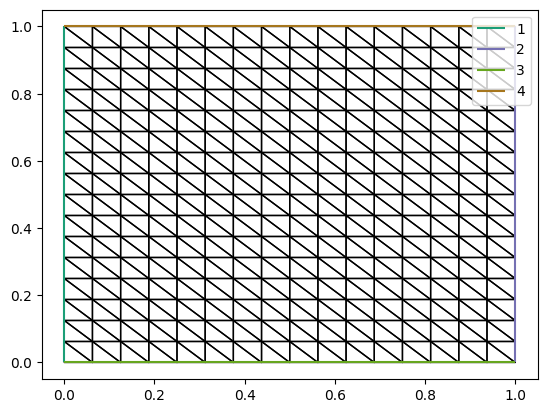

In [2]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
firedrake.triplot(mesh, axes=axes)
axes.legend();

### Functions

We can make scalar and vector fields defined on this mesh by interpolating the values of an algebraic expression to some space of functions.

First, we have to construct a function space `Q`.
We already have a mesh, and we need to decide what element family and polynomial degree.
In almost all the cases you'll encounter, the element family consists of continuous piecewise-polynomial functions in each triangle, which is abbreviated to `CG` for "continuous Galerkin".

Next, we have to make an expression for the function and interpolate it to the function space `Q`.
The function `firedrake.SpatialCoordinate` returns two symbolic objects `x`, `y` for the coordinates of each point of the mesh.
We can then use these symbols to define expressions for the function we'd like to analyze.
In this case, I've chosen the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function).
Firedrake has built-in functions for evaluating various transcendental functions of the coordinates, for example the sine, cosine, exponential, logarithm, etc.
To see all of the available functions, you can check the namespace `ufl.operators`.

Finally, the function `firedrake.interpolate` takes in an expression and a function space, and returns a field from that function space.
In the code below, the variable `expr` is a purely symbolic object.
The variable `q` on the other hand represents what happens when that expression gets interpolated to some function space.
The space we've chosen can represent polynomials up to degree 2 within each triangle, whereas the expression we're interpolating has polynomials up to degree four.
So there can be some loss of precision when we interpolate an expression to a function space.

In [3]:
Q = firedrake.FunctionSpace(mesh, family="CG", degree=2)

x, y = firedrake.SpatialCoordinate(mesh)
a = firedrake.Constant(0.5)
b = firedrake.Constant(10.0)
expr = (a - x)**2 + b*(y - x**2)**2
q = firedrake.interpolate(expr, Q)

Here we've defined the variables $a$ and $b$ as a `firedrake.Constant`.
We could have left these as just the floating-point numbers `0.5` and `10.0` and the code still would have worked.
In general you'll want to making something a `Constant` if its value could change from one run of the program to another.
For example, we might want to look at how the shape of this function changes as we alter the parameters.

Next we'll make a contour plot of the the function we just created.
The functions `tricontour`, `tricontourf`, `tripcolor`, and `quiver` are just wrappers around the equivalent functions in matplotlib.
If you haven't used matplotlib before, you can consult their [example code](https://matplotlib.org/gallery/images_contours_and_fields/tripcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-tripcolor-demo-py) to see how these functions work.

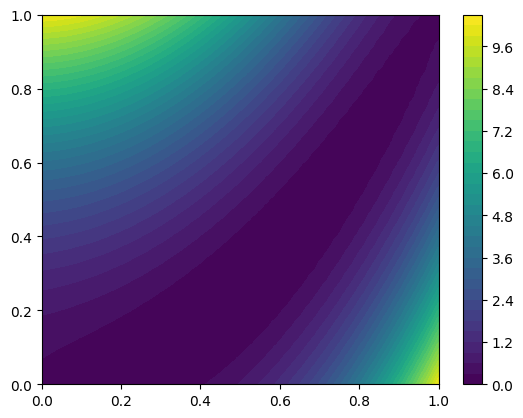

In [4]:
fig, axes = plt.subplots()
contours = firedrake.tricontourf(q, 36, axes=axes)
fig.colorbar(contours);

We can make vector fields in much the same way as we make scalar fields.
There are two key differences.
First, we have to put the expression we want inside the function `as_vector` in order to specify that we want a field with more than one component.
(There's also an `as_tensor` function if you want a matrix field.)
Second, we have to interpolate into a vector function space.
Here we'll make a vector field representing the negative gradient of the Rosenbrock function that we just defined above.

In [5]:
from firedrake import as_vector
expr = as_vector(
    (
        2 * (a - x) + 4 * b * x * (y - x**2),
        -2 * b * (y - x**2),
    )
)

V = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2)
v = firedrake.interpolate(expr, V)

There are many ways to plot a vector field.
Here we show a plot of the streamlines of the vector field, colored according to the magnitude of the vector.
This method is expensive, especially if you set the resolution or spacing of the streamlines to be too small, but nonetheless it produces really nice graphics.

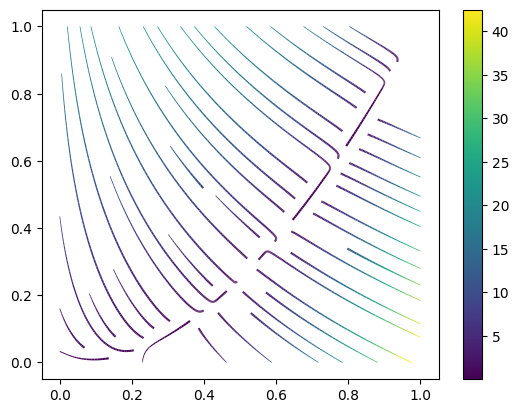

In [6]:
fig, axes = plt.subplots()
opts = {"resolution": 1 / 32, "seed": 1}
streamlines = firedrake.streamplot(v, axes=axes, **opts)
fig.colorbar(streamlines);

### Post-processing

We've shown above how to plot what a scalar or vector field looks like, but there's more to analyzing the results of simulations than just making pretty pictures.
For starters, you might also want to evaluate scalar or vector fields at points in the domain:

In [7]:
z = (a, a**2)
print(q(z))
print(v(z))

-3.122502256758253e-17
[-6.65662789e-16  6.61371029e-16]


Firedrake also provides a rich set of operations for evaluating integral expressions of scalar and vector fields.
Much like how the function `SpatialCoordinate` gives you two symbols `x`, `y` that represent the coordinates of each point of the mesh, firedrake also provides an object `dx` that represents the differential area element.
To define an integral, we multiply an expression by `dx`.
This gives back a purely symbolic object representing a recipe for computing an integral; we haven't yet evaluated it to get a real number.
The function `firedrake.assemble` actually evaluates this symbolic expression to give us a number.

In [8]:
from firedrake import inner, dx, assemble
print(assemble(x * y * dx))
print(assemble(q * dx))
print(assemble(inner(v, v) * dx))

0.25
2.083334604899085
172.01609669791267


This is similar to `interpolate`; expressions defining fields are purely symbolic until we `interpolate` them to a function space. 
Likewise, expressions defining integrals are purely symbolic until we `assemble` them to get a real number.

We can also evaluate integrals over the boundary of the mesh rather than the interior.
Boundary integrals are specified using the surface measure `ds` instead of `dx`.

In [ ]:
from firedrake import ds
print(assemble(q * ds))

We might also need more fine-grained control over which part of the boundary we're integrating over.
The mesh plot we created earlier shows the numbering of the boundary segments.
We can specify which boundary segment to integrate over by passing the corresponding numeric ID to `ds`; these are the same IDs that are color-coded in the mesh plot above.
You can also pass a tuple of IDs to integrate over multiple segments.

In [ ]:
print(assemble(q * ds(2)))

ids = (1, 2)
print(assemble(q * ds(ids)))

Finally, a common operation we'll need in the tutorials that follow is to evaluate the flux of a vector field $v$ across the boundary of the domain.
The mathematical definition of this quantity is the integral

$$F = \int_{\partial\Omega}v\cdot n\, ds$$

where $n$ is the unit outward-pointing normal vector.
So we'll also need a symbolic representation of the outward-pointing normal; this comes from the function `firedrake.FacetNormal`.

In [ ]:
n = firedrake.FacetNormal(mesh)
print(assemble(inner(v, n) * ds))

### Common useful functions

In the tutorials that follow, we'll often have to synthesize some field -- an ice thickness or bed elevation for example -- with a shape that mimics a feature of a real physical system.
There are a few especially useful functions for doing this.
First, the hyperbolic tangent function

$$\tanh z = \frac{\sinh z}{\cosh z}$$

goes from -1 in the limit as $z \to -\infty$ and to +1 as $z \to +\infty$.
Firedrake also defines symbolic expressions involving transcendental functions like the exponential, logarithm, sine, and cosine.

In [ ]:
from firedrake import exp

def sinh(z):
    return (exp(z) - exp(-z)) / 2

def cosh(z):
    return (exp(z) + exp(-z)) / 2

def tanh(z):
    return sinh(z) / cosh(z)

By shifting and rescaling the output tanh function or its argument, we can create ramping functions that go from one value to another over some length scale that we choose.
Here we'll create a ramp function that goes from a value $a$ to a value $b$ over a distance $\delta = 1/8$ across the diagonal line through the center of the domain.

In [ ]:
a = firedrake.Constant(-2)
b = firedrake.Constant(+3)
x_0 = firedrake.Constant(1/2)
y_0 = firedrake.Constant(1/2)
δ = firedrake.Constant(1/8)

w = (x - x_0) / δ + (y - y_0) / δ
expr = a + (b - a) * (tanh(w) + 1) / 2
ramp = firedrake.interpolate(expr, Q)

Just to help visualize this a little better, we'll make a 3D plot.

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(ramp, axes=axes);

We can get more creative about what the argument to the tanh function is to create ramps around more interesting shapes.
Below, we'll create a ramping function around a circle of radius 1/4 in the middle of the domain.

In [ ]:
from firedrake import sqrt
r = sqrt((x - x_0)**2 + (y - y_0)**2)
R = firedrake.Constant(1/4)
ϵ = firedrake.Constant(1/16)
expr = tanh((R - r) / ϵ)
ramp = firedrake.interpolate(expr, Q)

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(projection="3d")
firedrake.trisurf(ramp, axes=axes);

The next useful shaping function is hyperbolic secant:

$$\text{sech}\,z = \frac{1}{\cosh z}.$$

This is good for making bumps.

In [ ]:
def sech(z):
    return 1 / cosh(z)

expr = sech(r / δ)
bump = firedrake.interpolate(expr, Q)

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(bump, axes=axes);

Depending on how sharp a cutoff is necessary, it's also possible to use other bump functions like $e^{-z^2}$, $\text{sech}^2$, and so forth.
Again, by being a little creative about the argument to the sech function, we can make more interesting fields.
Here we'll create a ridge at the circle of radius 1/4 about the center of the domain.

In [ ]:
expr = sech((r - R) / δ)
ridge = firedrake.interpolate(expr, Q)

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(projection="3d")
firedrake.trisurf(ridge, axes=axes);

We'll use combinations of bump, ramp, and polynomials functions several times in the tutorials that follow in order to synthesize fields like a bed topography with a desired shape.
For example, we'll use the ridge shape above to emulate a mountain range in the next tutorial.

### Conclusion

Icepack uses the functions in Firedrake to implement solvers for the various physics problems that show up in ice sheet modeling.
The Firedrake routines that we've shown here can be used for analyzing simulation results, either through visualization, evaluating fields at points, or evaluating integrals of fields.
They can also be used to define input fields of simulations, if those fields have a simple analytical expression.
In the next tutorial, we'll show how to use icepack to solve for the velocity and thickness of a an ice sheet with a synthetic geometry.
In later tutorials, we'll show how to use real observational data sets, as well as more complicated geometries imported from mesh generators.

To learn more about Firedrake, you can visit their [documentation](http://www.firedrakeproject.org/documentation.html) or check out some of the [demos](http://www.firedrakeproject.org/notebooks.html).